In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import toeplitz
from sklearn.preprocessing import PolynomialFeatures
from scipy import sparse
from scipy.sparse.linalg import spsolve_triangular

In [64]:
# ------------------------------------------------------------------------
# 1) Dictionary Class for Modular Lifting
# ------------------------------------------------------------------------
class Dictionary:
    def __init__(self, method="polynomial", **kwargs):
        """
        Initialize the dictionary with a chosen method.

        Available methods:
        - 'polynomial': Polynomial basis up to 'degree'
        - 'rbf': Radial basis functions with 'centers' and 'gamma'
        """
        self.method = method
        self.params = kwargs

    def transform(self, X):
        """
        Lift input X into a higher-dimensional space.
        X should be shape (N_samples, N_features).
        Returns shape (N_samples, N_lifted_features).
        """
        if self.method == "polynomial":
            return self._poly_dictionary(X, self.params.get("degree", 2))
        elif self.method == "poly_cross":
            return self._poly_cross_dictionary(X, self.params.get("degree", 2))
        elif self.method == "rbf":
            return self._rbf_dictionary(X,
                                        self.params.get("centers", None),
                                        self.params.get("gamma", 1.0))
        else:
            raise ValueError(f"Unknown dictionary method: {self.method}")

    def _poly_dictionary(self, X, degree=2):
        """Simple polynomial features up to 'degree' (no cross-terms)."""
        N, D = X.shape
        # Start with constant term
        Phi = [np.ones(N)]
        # Add powers of each feature up to 'degree'
        for d in range(1, degree+1):
            for i in range(D):
                Phi.append(X[:, i]**d)
        return np.vstack(Phi).T

    def _poly_cross_dictionary(self, X, degree=2):
        """
        Polynomial features including cross terms up to 'degree' = 2.
        e.g. for D=3, we get:
          [1, x1, x2, x3, x1^2, x2^2, x3^2, x1*x2, x1*x3, x2*x3].
        Extend similarly if you need higher degrees.
        """
        N, D = X.shape
        Phi = [np.ones(N)]  # constant term

        if degree >= 1:
            # linear terms: x1, x2, ...
            for i in range(D):
                Phi.append(X[:, i])
        if degree >= 2:
            # squares: x1^2, x2^2, ...
            for i in range(D):
                Phi.append(X[:, i]**2)
            # cross terms: x1*x2, x1*x3, etc.
            for i in range(D):
                for j in range(i+1, D):
                    Phi.append(X[:, i] * X[:, j])

        return np.vstack(Phi).T

    def _rbf_dictionary(self, X, centers=None, gamma=1.0):
        """Radial Basis Function dictionary with optional 'centers'."""
        N, D = X.shape
        if centers is None:
            # Create 5 equally spaced centers per dimension
            # (for illustration; adjust as needed)
            centers = []
            for dim in range(D):
                c_lin = np.linspace(np.min(X[:,dim]), np.max(X[:,dim]), 5)
                centers.append(c_lin)
            # Create all combinations of centers across dimensions
            from itertools import product
            centers = np.array(list(product(*centers)))
        # Build RBF features
        Phi = [np.ones(N)]
        for center in centers:
            dist_sq = np.sum((X - center)**2, axis=1)
            Phi.append(np.exp(-gamma * dist_sq))
        return np.vstack(Phi).T

In [101]:
import numpy as np

class MatrixDictionary:
    """
    A dictionary class that takes an n x n matrix and
    returns a block matrix stacking constant, linear, and
    higher-order powers of each element.
    """
    def __init__(self, degree=2):
        """
        degree=2 means we will produce blocks for
         1) constant term,
         2) the matrix (M^1),
         3) the matrix squared elementwise (M^2).
        """
        self.degree = degree

    def transform(self, M):
        """
        M: An n x n numpy array.
        Returns: A block matrix of size ((degree+1)*n) x n.

        Example for degree=2:
            Block 1 (top):  all ones      (n x n)
            Block 2 (middle): M           (n x n)
            Block 3 (bottom): M**2        (n x n)
        """
        if M.ndim != 2 or M.shape[0] != M.shape[1]:
            raise ValueError("Input must be a square matrix.")

        n = M.shape[0]

        # List of blocks to stack vertically
        # 1) Constant term
        #blocks = [np.ones((n, n))]
        blocks = []

        # 2) Polynomial powers of M (elementwise)
        for d in range(1, self.degree + 1):
            blocks.append(M**d)  # elementwise power

        # Stack blocks vertically: shape = ((degree+1)*n, n)
        return np.vstack(blocks)



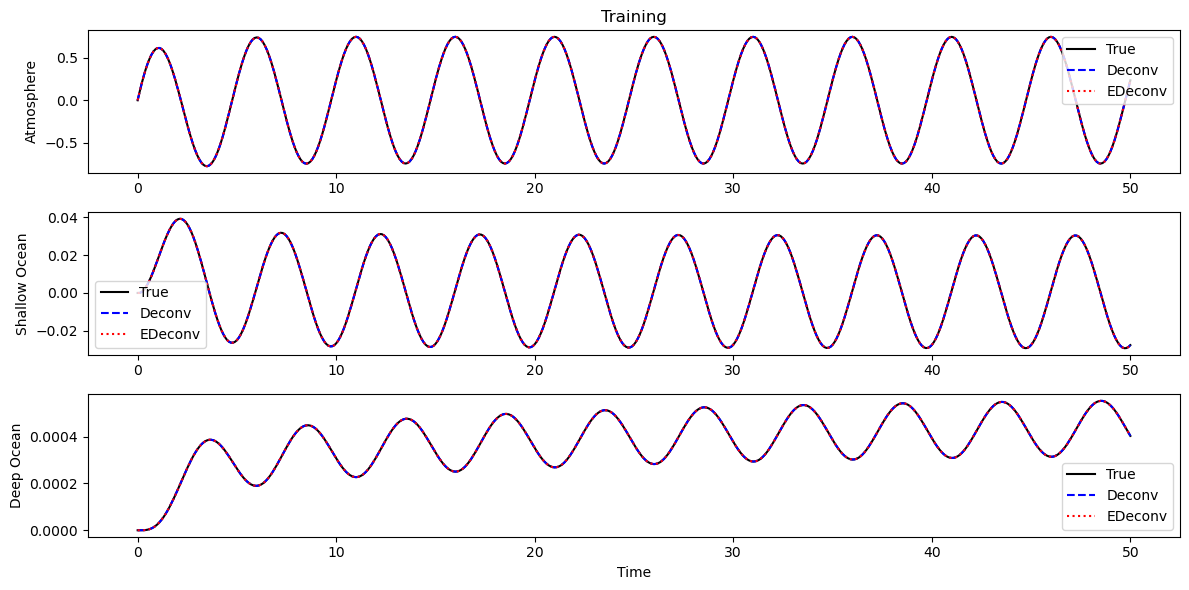

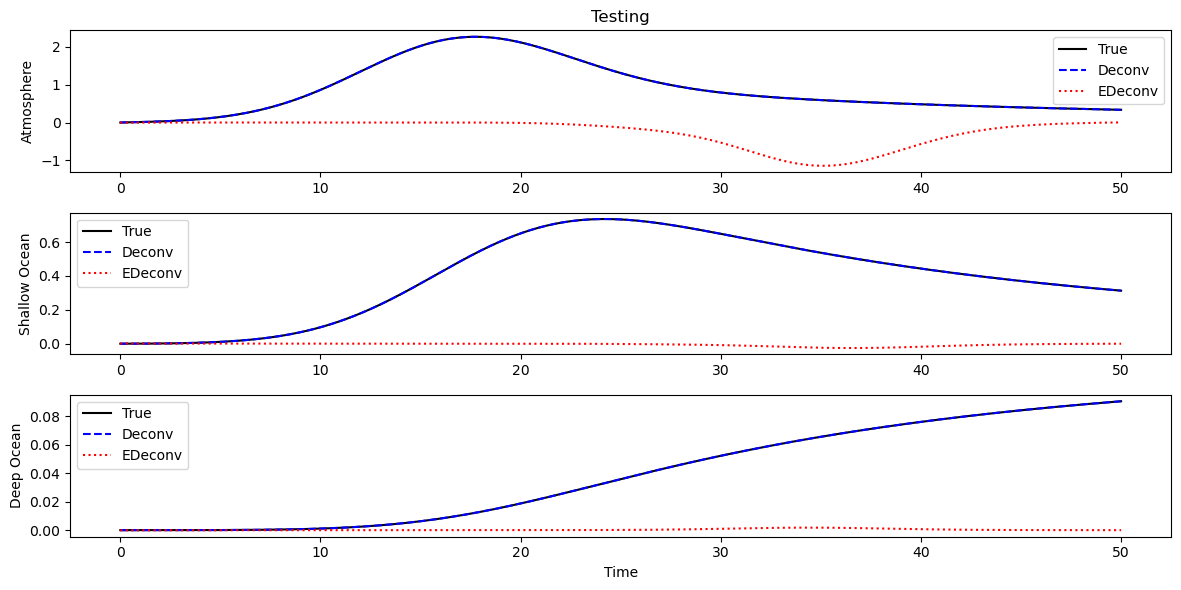

2.4159585090445192e-15 5.061218478323813e-14
3.381041235347761e-13 31.46228170797482


In [117]:
# ------------------------------------------------------------------------
# 2) Three-Box Model Integration with Known Forcing B
# ------------------------------------------------------------------------
# Heat capacities
c = np.array([1.0, 10.0, 100.0])

# Coupling matrix L
L = np.array([
    [-0.5,  0.5,  0.0],
    [ 0.5, -1.0,  0.5],
    [ 0.0,  0.5, -0.5]
])
# Construct continuous-time system matrix A
A_ct = np.zeros_like(L)
for i in range(3):
    A_ct[i, :] = L[i, :] / c[i]

# Forcing enters only the atmosphere (box 1)
B = np.array([[1.0], [0.0], [0.0]])

def gaussian_forcing(t, t0=15, sigma=5):
    return np.exp(-((t - t0)**2)/(2*sigma**2))

def sinusoidal_forcing(t, freq=0.2):
    return np.cos(2*np.pi*freq*t)

def integrate_3box(forcing_func, dt=0.1, T_max=50, x0=np.array([10,5,0])):
    """
    Integrate the forced 3-box model using forward Euler in discrete time.
    x_{k+1} = x_k + dt * (A_ct x_k + B u_k)
    Returns (t_vals, X, U).
    """
    t_vals = np.arange(0, T_max+dt, dt)
    n_steps = len(t_vals)
    X = np.zeros((3, n_steps))
    U = np.zeros((1, n_steps))
    X[:,0] = x0

    for k in range(0, n_steps - 1):
        u_k = forcing_func(t_vals[k])
        U[0,k] = u_k
        X[:,k+1] = X[:, k] + dt * (A_ct @ X[:,k] + B.flatten()*u_k)
    return t_vals, X, U


# ------------------------------------------------------------------------
# 3) Deconvolution (Fit and Predict)
# ------------------------------------------------------------------------
def deconv_fit(X, F):
    F_toeplitz = sparse.csr_matrix(toeplitz(F, np.zeros_like(F)))
    return spsolve_triangular(F_toeplitz, X.T, lower=True)

def edeconv_fit(X, F, dictionary, matrix_dictionary):
    F_toeplitz = toeplitz(F, np.zeros_like(F))
    Psi_F = matrix_dictionary.transform(F_toeplitz)
    Phi_X = dictionary.transform(X.T)

    return (Phi_X.T @ np.linalg.pinv(Psi_F)).T

def deconv_predict(G, F):
    F_toeplitz = sparse.csr_matrix(toeplitz(F, np.zeros_like(F)))
    return (F_toeplitz @ G).T

def edeconv_predict(G, F, matrix_dictionary):
    F_toeplitz = toeplitz(F, np.zeros_like(F))
    Psi_F = matrix_dictionary.transform(F_toeplitz)

    return (Psi_F.T @ G[:,1:4]).T

# ------------------------------------------------------------------------
# 4) Run Training (Gaussian) and Testing (Sinusoidal)
# ------------------------------------------------------------------------
# 1. Integrate with Gaussian forcing (training data)
dt = 0.1
T_max = 50
x0 = np.array([0, 0, 0])
#t_train, X_train, U_train = integrate_3box(gaussian_forcing, dt, T_max, x0)
t_train, X_train, U_train = integrate_3box(sinusoidal_forcing, dt, T_max, x0)
n_train = X_train.shape[1]

# 2. Choose a dictionary (change method for experiments)
dictionary = Dictionary(method='polynomial', degree=2)
matrix_dictionary = MatrixDictionary(degree=2)

# 3. Fit Deconvolution operator
G = deconv_fit(X_train, U_train)
X_deconv_train = deconv_predict(G, U_train)

G_edeconv = edeconv_fit(X_train, U_train, dictionary, matrix_dictionary)
X_edeconv_train = edeconv_predict(G_edeconv, U_train, matrix_dictionary)

# 5. Integrate with Sinusoidal forcing (test data)
#t_test, X_test_true, U_test = integrate_3box(sinusoidal_forcing, dt, T_max, x0)
t_test, X_test_true, U_test = integrate_3box(gaussian_forcing, dt, T_max, x0)
n_test = X_test_true.shape[1]

# 6. Predict on test data (sinusoidal forcing)
X_deconv_test = deconv_predict(G, U_test)
X_edeconv_test = edeconv_predict(G_edeconv, U_test, matrix_dictionary)

# 7. Plot results
labels = ['Atmosphere', 'Shallow Ocean', 'Deep Ocean']

# --- Training Performance ---

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t_train, X_train[i, :], 'k-', label=f'True')
    plt.plot(t_train, X_deconv_train[i, :], 'b--', label=f'Deconv')
    plt.plot(t_train, X_edeconv_train[i, :], 'r:', label='EDeconv')
    plt.ylabel(labels[i])
    if i == 0:
        plt.title('Training')
    if i == 2:
        plt.xlabel('Time')
    plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t_train, X_test_true[i, :], 'k-', label=f'True')
    plt.plot(t_train, X_deconv_test[i, :], 'b--', label=f'Deconv')
    plt.plot(t_train, X_edeconv_test[i, :], 'r:', label='EDeconv')
    plt.ylabel(labels[i])
    if i == 0:
        plt.title('Testing')
    if i == 2:
        plt.xlabel('Time')
    plt.legend()
plt.tight_layout()
plt.show()

print(np.linalg.norm(X_train - X_deconv_train), np.linalg.norm(X_train - X_edeconv_train))
print(np.linalg.norm(X_test_true - X_deconv_test), np.linalg.norm(X_test_true - X_edeconv_test))